
# Projeto - Analise de preços de jogos na Steam
### Alunos:

- Gabriel Citroni Uliana - 9779367
- Ewerton Patrick Silva do Amaral - 10346975
- Fernando Akio Tutume de Salles Pucci - 8957197

In [ ]:
# Autorize o Collab a acessar seus arquivos no drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import scipy as sp
df = pd.read_csv("/content/drive/Shareddrives/Ciencia de Dados/artigo/steam_processed_no_low_review.csv", na_values='?')

# excluindo colunas desnecessarias
del df["Nome"]

# separando classe de df
raw_df = df.copy()
classe = df["Preço"].copy()
classe_df = pd.DataFrame(df["Preço"])
del df["Preço"]

df


,Desenvolvedor,Distribuidora,Indie,Quantidade de Review,Review Médio,Plataforma,Singleplayer,Multiplayer,Data de Lançamento,Linguagens Interface,Linguagens Dublagem,Linguagens Legenda,Processador,Memória Ram,Placa de Vídeo,Espaço em Disco
0,Ubisoft Montreal,Ubisoft,Não,672417,Very Positive,1,Sim,Sim,antigo,16.0,8.0,15.0,INTEL-CORE-I5-2500K,8.000,NVIDIA-GEFORCE-GTX-670,61.00
1,Outros,Outros,Não,145739,Overwhelmingly Positive,1,Não,Sim,novo,25.0,1.0,NaN,outros,8.000,NVIDIA-GTX-970,18.00
2,Outros,Outros,Sim,86806,Overwhelmingly Positive,2,Sim,Não,novo,10.0,1.0,10.0,outros,8.000,outros,20.00
3,Outros,Outros,Não,294141,Very Positive,1,Não,Sim,antigo,15.0,3.0,17.0,INTEL-CORE-I3-4170,8.000,GEFORCE-760,50.00
4,Outros,Outros,Não,869213,Very Positive,1,Sim,Sim,antigo,13.0,1.0,13.0,INTEL-CORE-I5-3470,8.000,NVIDIA-GTX-660,72.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,Outros,Iceberg Interactive,Sim,321,Very Negative,1,Sim,Não,antigo,2.0,NaN,NaN,outros,4.000,outros,1.15
4839,Outros,Outros,Sim,71,Very Negative,1,Sim,Sim,antigo,3.0,NaN,NaN,outros,6.000,outros,6.00
4840,Outros,Outros,Não,239,Very Negative,1,Sim,Não,antigo,4.0,NaN,NaN,outros,4.096,outros,0.65
4841,Outros,Outros,Sim,61,Very Negative,1,Não,Não,antigo,1.0,1.0,NaN,outros,8.000,NVIDIA-8000,2.00


## Balanceamento de dados

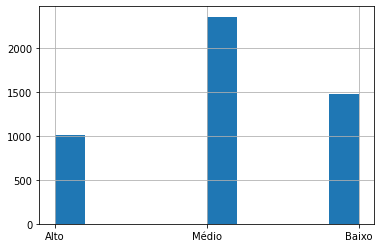

In [ ]:
classe.hist()

Baixo
[      Preço
4004  Baixo
2822  Baixo
3522  Baixo
4687  Baixo
2795  Baixo
...     ...
4425  Baixo
4147  Baixo
4750  Baixo
4346  Baixo
3227  Baixo

[1614 rows x 1 columns]]


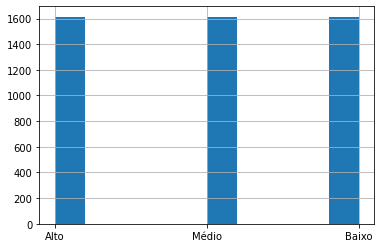

In [ ]:
def undersample(inputs, targets):

  target_counts = targets.value_counts()

  #adquirindo attributos predomintantes
  target_maxcount = int(target_counts.describe()['max'])
  target_mincount = int(target_counts.describe()['min'])
  target_maxvalue = target_counts.idxmax()[0]
  target_minvalue = target_counts.idxmin()[0]

  to_undersample = inputs[targets.values == target_maxvalue]
  sampled = to_undersample.sample(n=target_mincount, replace=False)

  undersampled_inputs = pd.concat([inputs[targets.values == target_minvalue], 
                                  sampled])
  undersampled_target = pd.concat([targets[targets.values == target_minvalue], 
                                  targets[targets.values == target_minvalue].replace([target_minvalue], target_maxvalue)])
  return undersampled_inputs, undersampled_target



def balance_sample(inputs, target):

  max_class = target.value_counts().idxmax()[0]

  min_class = target.value_counts().idxmin()[0]
  n_samples = int(inputs.shape[0]/3)

  #realiza o oversample para tamanho_dataset/3
  aux_target = target[target["Preço"] == min_class]
  aux_inputs = inputs[target["Preço"] == min_class]
  #expande as samples de cada dataframe
  oversamples_target = aux_target.sample(n=n_samples, replace=True)
  oversamples_inputs = aux_inputs.sample(n=n_samples, replace=True)

  #realiza o undersample para tamanho_dataset/3
  aux_target = target[target["Preço"] == max_class]
  aux_inputs = inputs[target["Preço"] == max_class]
  #retira as samples de cada dataframe
  undersamples_target = aux_target.sample(n=n_samples, replace=False)
  undersamples_inputs = aux_inputs.sample(n=n_samples, replace=False)

  #realiza balanceamento de outras classes que nao sao max ou min

  other_samples_target = []
  other_samples_inputs = []
  all_values = target.value_counts() 
  all_labels = all_values.axes
  for label in all_labels[0]:
    label = label[0]
    if label != max_class and label != min_class:
      aux_target = target[target["Preço"] == label]
      aux_inputs = inputs[target["Preço"] == label]
      print(label)
      if all_values[label][0] < n_samples: # oversamples
        other_samples_target.append(aux_target.sample(n=n_samples, replace=True))
        other_samples_inputs.append(aux_inputs.sample(n=n_samples, replace=True))
      else: #undersample
        other_samples_target.append(aux_target.sample(n=n_samples, replace=False))
        other_samples_inputs.append(aux_inputs.sample(n=n_samples, replace=False))

  print(other_samples_target)
  #concatenando os dados
  dualsampled_target = pd.concat([oversamples_target, undersamples_target, *other_samples_target])
  dualsampled_inputs = pd.concat([oversamples_inputs, undersamples_inputs, *other_samples_inputs])
  return dualsampled_inputs, dualsampled_target

balanced_df, balanced_classe = balance_sample(df, classe_df)

balanced_classe["Preço"].hist()

## Analise da matriz de correlacao para os dados

In [ ]:
balanced_df.reset_index(drop=True, inplace=True)
balanced_classe.reset_index(drop=True, inplace=True)
data_to_corr = pd.concat([balanced_df, balanced_classe], axis=1)
print(data_to_corr)

     Desenvolvedor  ...  Preço
0         Tamsoft   ...   Alto
1           Outros  ...   Alto
2           Outros  ...   Alto
3     Codemasters   ...   Alto
4           Outros  ...   Alto
...            ...  ...    ...
4837        Outros  ...  Baixo
4838        Outros  ...  Baixo
4839   Frozenbyte   ...  Baixo
4840        Outros  ...  Baixo
4841        Outros  ...  Baixo

[4842 rows x 17 columns]


In [ ]:
# Para analisar a matriz de correlacao vamos descartar os dados categoricos que possuem  muito valores,
# como desenvolvedora, distribuidora, placa de video e processado


other_categorical_data = pd.DataFrame()
other_categorical_data["Distribuidora"] = data_to_corr["Distribuidora"].copy()
other_categorical_data["Desenvolvedor"] = data_to_corr["Desenvolvedor"].copy()
other_categorical_data["Processador"] = data_to_corr["Processador"].copy()
other_categorical_data["Placa de Vídeo"] = data_to_corr["Placa de Vídeo"].copy()

del data_to_corr["Distribuidora"]
del data_to_corr["Desenvolvedor"]
del data_to_corr["Processador"]
del data_to_corr["Placa de Vídeo"]

other_categorical_data




,Distribuidora,Desenvolvedor,Processador,Placa de Vídeo
0,"XSEED Games, Marvelous USA, Inc., Marvelous",Tamsoft,INTEL-CORE-I5-6400,NVIDIA-GEFORCE-GTX-950
1,2K,Outros,INTEL-CORE-I3-2105,GEFORCE-GTX-760
2,Outros,Outros,INTEL-CORE-I5-,GEFORCE-970
3,Codemasters,Codemasters,INTEL-CORE-I5-8600K,NVIDIA-GTX-1060
4,Strategy First,Outros,outros,outros
...,...,...,...,...
4837,Outros,Outros,outros,outros
4838,Outros,Outros,outros,outros
4839,Outros,Frozenbyte,outros,NVIDIA-GEFORCE-GTX-560
4840,Outros,Outros,INTEL-CORE-I5-,GEFORCE-GTX-670


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Vamos transformar os dados categoricos para realizar a correlacao dos dados categoricos

# Vetor dos atributos numéricos e categóricos
features_numericos = ["Quantidade de Review", "Plataforma", "Linguagens Interface", "Linguagens Dublagem", "Linguagens Legenda", "Memória Ram", "Espaço em Disco"]
features_categoricos = ["Indie", "Review Médio", "Singleplayer", "Multiplayer", "Data de Lançamento", "Preço"]

# Criando os pipeline
pipeline_numerico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])#alterando a escala, z = (x-u)/s

pipeline_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())])

# Criando a transformação do conjunto de dados
# Seguindo primeiro a ordem numerica e depois as categorias
transformacao = ColumnTransformer(
    transformers=[
        ('transformacao numerica', pipeline_numerico, features_numericos),
        ('transformacao categorica', pipeline_categorico, features_categoricos),        
    ])

# Aplicando a transformação no dataset:
dados_transformados = transformacao.fit_transform(data_to_corr)
dados_transformados = np.round(dados_transformados, 2)



nomes = [] #guarda os nomes das colunas dos dados numericos
nomes += features_numericos

# Para os dados categóricos acessamos o transformador
transformacao_categorica = transformacao.transformers_[1]
# Depois o pipeline
pipeline_categorico = transformacao_categorica[1]
# E finalmente o onehot
transf_onehot = pipeline_categorico.named_steps['onehot']

# adicionando legenda aos atributos gerados pelo onehot
onehot_features = transf_onehot.get_feature_names().tolist()
aux_cat = []
for cat in features_categoricos:
  num_diff_values = len(data_to_corr[cat].unique())
  aux_cat.extend((cat for _ in range(num_diff_values)))

# Para acessar o nome das variáveis usamos o método get_feature_names()
nomes += [f"{aux_cat[i]} ({onehot_features[i][3:]})"  for i in range(len(aux_cat))]


data_to_corr = pd.DataFrame(data=dados_transformados, columns=nomes)

data_to_corr


,Quantidade de Review,Plataforma,Linguagens Interface,Linguagens Dublagem,Linguagens Legenda,Memória Ram,Espaço em Disco,Indie (Não),Indie (Sim),Review Médio (Mixed),Review Médio (Mostly Negative),Review Médio (Mostly Positive),Review Médio (Overwhelmingly Negative),Review Médio (Overwhelmingly Positive),Review Médio (Very Negative),Review Médio (Very Positive),Singleplayer (Não),Singleplayer (Sim),Multiplayer (Não),Multiplayer (Sim),Data de Lançamento (antigo),Data de Lançamento (novo),Preço (Alto),Preço (Baixo),Preço (Médio)
0,-0.02,-0.62,-0.36,-0.49,-0.72,0.49,0.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.08,-0.62,0.02,0.94,-0.03,-0.46,1.39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,-0.13,-0.62,0.77,-0.49,0.90,0.49,0.32,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.01,-0.62,0.77,1.23,0.67,0.49,3.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,-0.10,-0.62,0.39,0.00,0.00,0.49,0.16,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4837,-0.12,-0.62,-0.73,0.00,0.00,-0.94,-0.58,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4838,-0.03,1.96,4.33,7.54,5.29,-1.18,-0.58,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4839,-0.13,-0.62,0.77,0.00,0.90,0.49,-0.34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4840,-0.13,-0.62,-0.17,0.66,-0.26,0.49,-0.01,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


Plotando matriz de correalacao

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


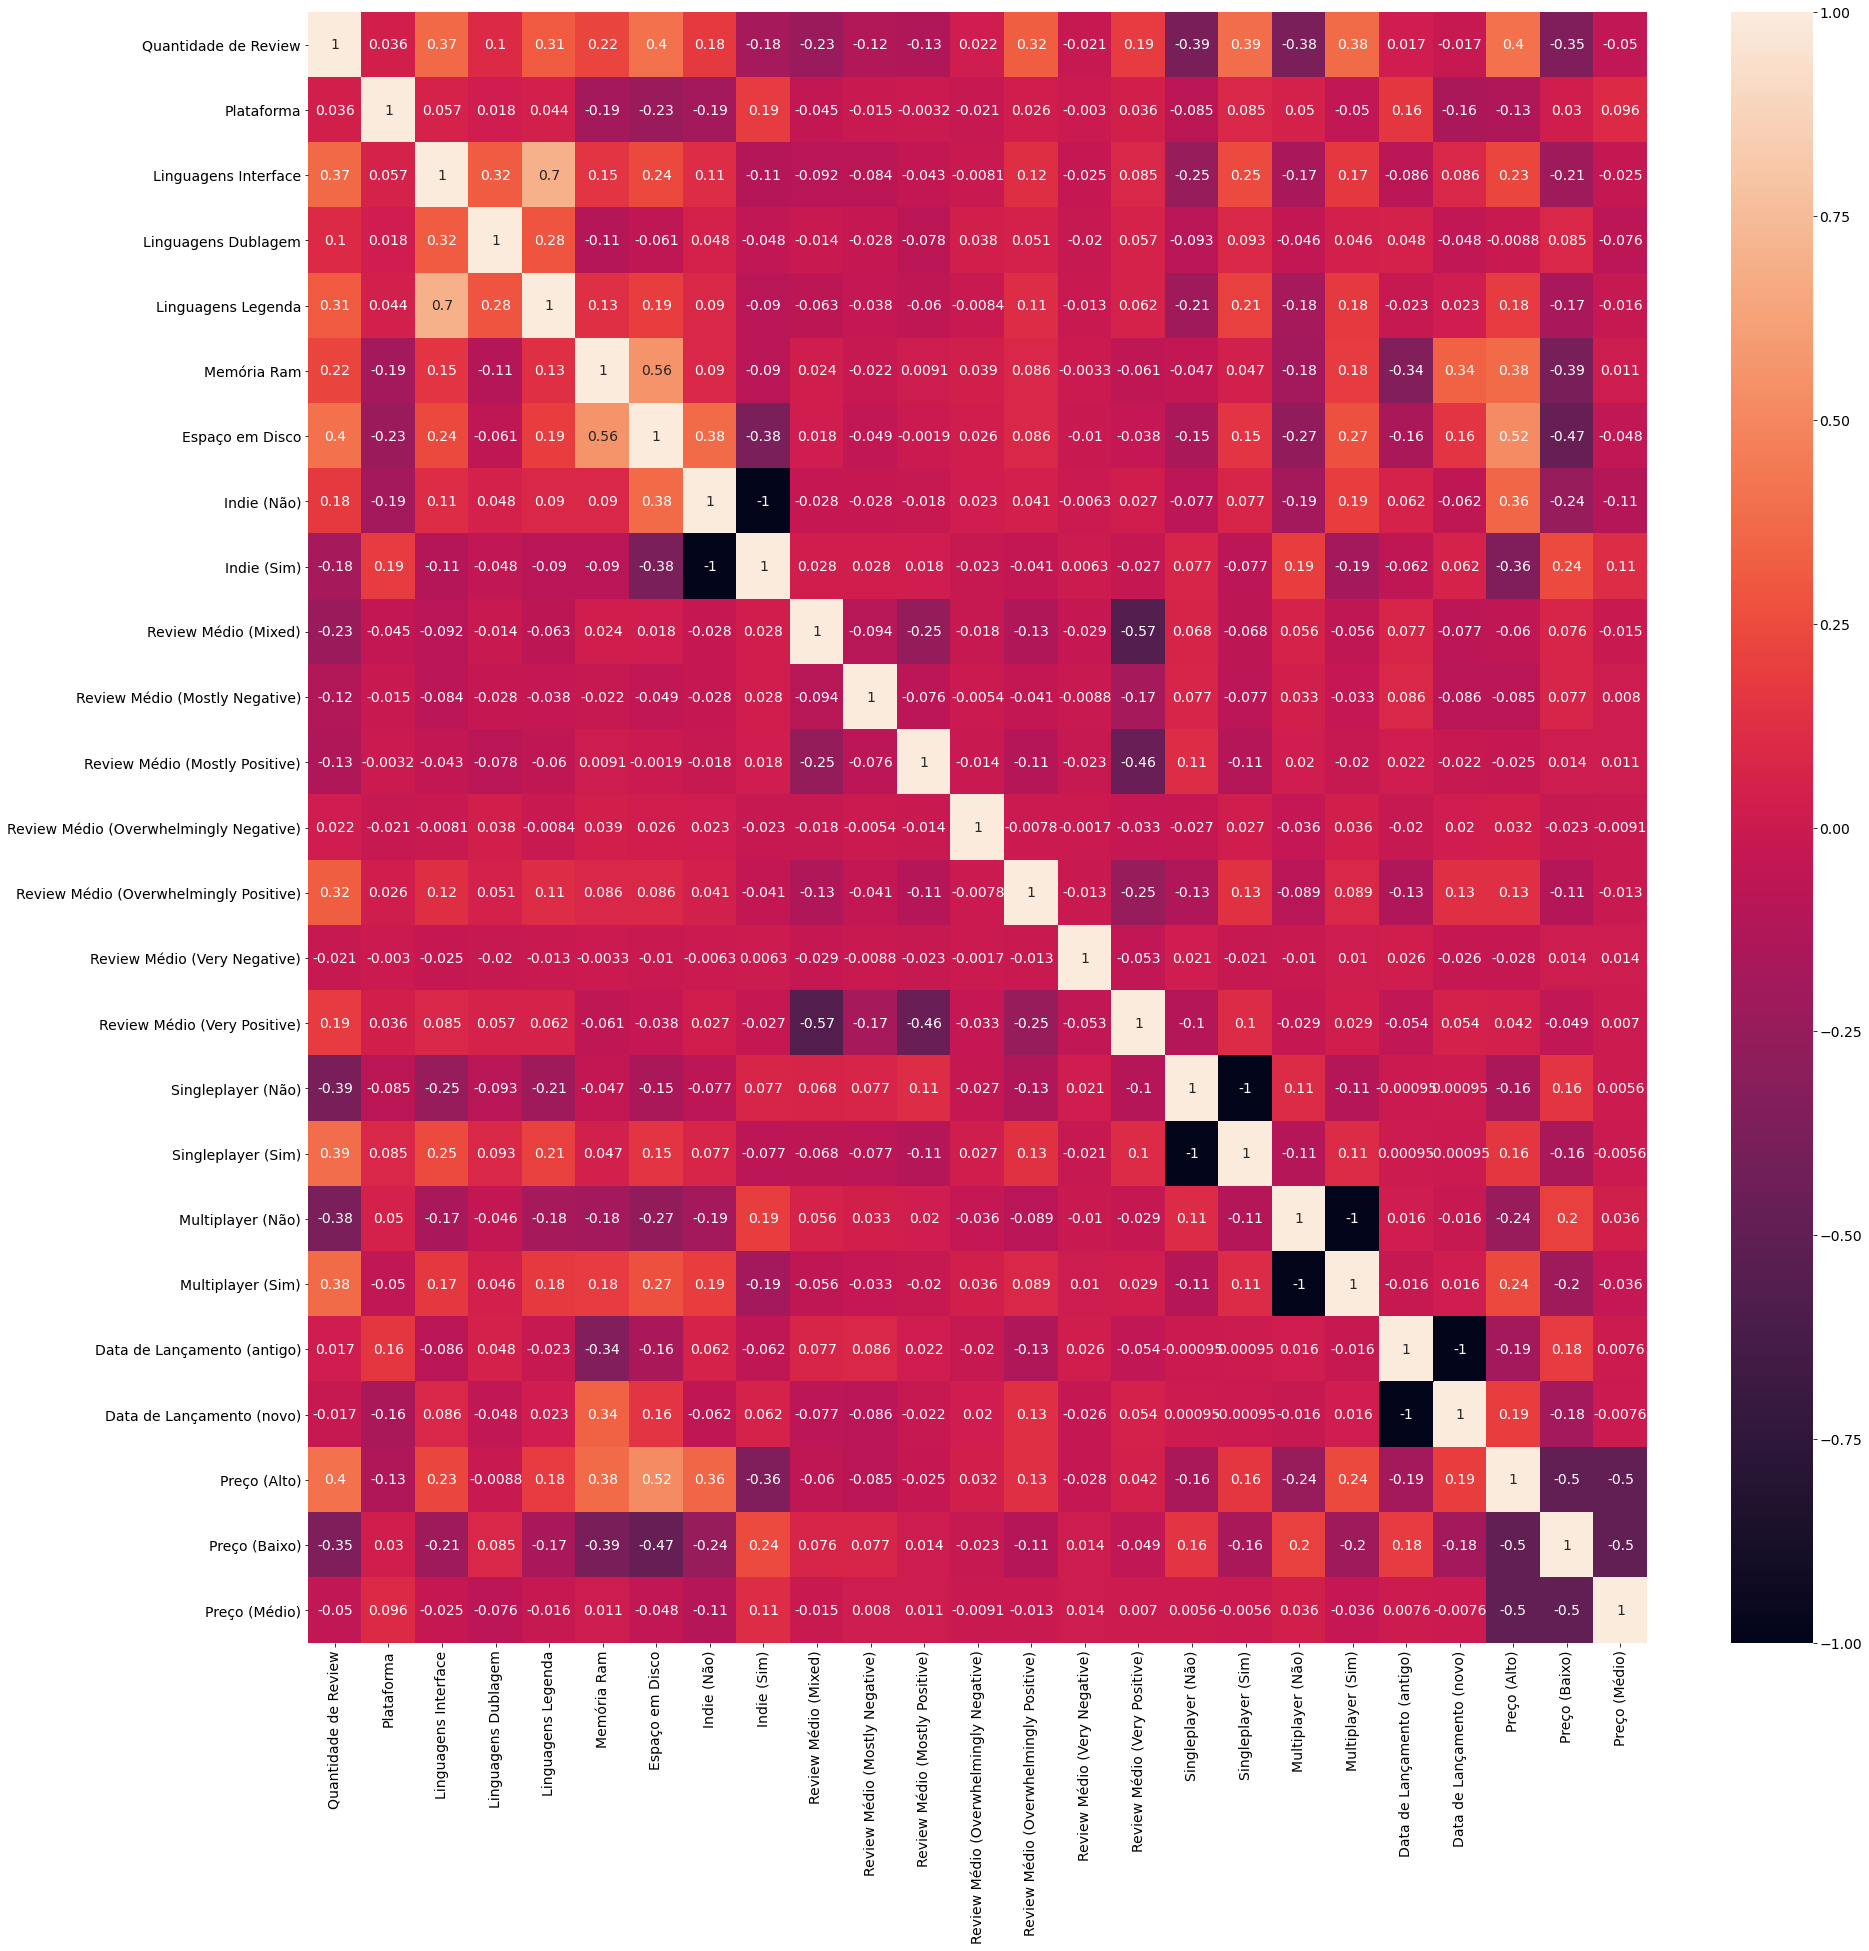

In [ ]:
data_corr = pd.DataFrame.corr(data_to_corr, method='spearman')

font = {'family' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
fig, ax = plt.subplots(figsize=(30,30), )         # Sample figsize in inches

seaborn.heatmap(data_corr, annot=True, ax=ax)

### Selecionando as variaveis mais relevantes de acordo com a variavel alvo

In [ ]:
import seaborn

data_corr_abs = data_corr.transform(lambda x: abs(x))
relevant_vars = data_corr_abs['Preço (Alto)'].sort_values()[-12:-1]

relevant_vars.pop("Preço (Baixo)")
relevant_vars.pop("Preço (Médio)")
print(relevant_vars)

Data de Lançamento (antigo)    0.188752
Linguagens Interface           0.233080
Multiplayer (Não)              0.240188
Multiplayer (Sim)              0.240188
Indie (Não)                    0.358499
Indie (Sim)                    0.358499
Memória Ram                    0.378967
Quantidade de Review           0.403360
Espaço em Disco                0.520708
Name: Preço (Alto), dtype: float64


In [ ]:
X = pd.DataFrame()
for name, _ in relevant_vars.items():
  X[name] = data_to_corr[name]

X

,Data de Lançamento (antigo),Linguagens Interface,Multiplayer (Não),Multiplayer (Sim),Indie (Não),Indie (Sim),Memória Ram,Quantidade de Review,Espaço em Disco
0,1.0,-0.36,0.0,1.0,1.0,0.0,0.49,-0.02,0.90
1,0.0,0.02,0.0,1.0,1.0,0.0,-0.46,0.08,1.39
2,0.0,0.77,1.0,0.0,0.0,1.0,0.49,-0.13,0.32
3,1.0,0.77,0.0,1.0,1.0,0.0,0.49,-0.01,3.45
4,1.0,0.39,0.0,1.0,1.0,0.0,0.49,-0.10,0.16
...,...,...,...,...,...,...,...,...,...
4837,1.0,-0.73,1.0,0.0,0.0,1.0,-0.94,-0.12,-0.58
4838,0.0,4.33,0.0,1.0,0.0,1.0,-1.18,-0.03,-0.58
4839,0.0,0.77,0.0,1.0,1.0,0.0,0.49,-0.13,-0.34
4840,0.0,-0.17,1.0,0.0,0.0,1.0,0.49,-0.13,-0.01


Pre-processamento dos dados Desenvolvedor, Distribuidora, Processador e Placa de Video

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

features_categoricos = ["Desenvolvedor", "Distribuidora", "Processador", "Placa de Vídeo"]

pipeline_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())])

# Criando a transformação do conjunto de dados
# Seguindo primeiro a ordem numerica e depois as categorias
transformacao = ColumnTransformer(
    transformers=[
        ('transformacao categorica', pipeline_categorico, features_categoricos),        
    ])

# Aplicando a transformação no dataset:
categoricos_transformados = np.array(transformacao.fit_transform(other_categorical_data).toarray())
categoricos_transformados = np.round(categoricos_transformados, 2)

print(categoricos_transformados)

nomes = [] #guarda os nomes das colunas dos dados numericos

# Para os dados categóricos acessamos o transformador
transformacao_categorica = transformacao.transformers_[0]
# Depois o pipeline
pipeline_categorico = transformacao_categorica[1]
# E finalmente o onehot
transf_onehot = pipeline_categorico.named_steps['onehot']
# Para acessar o nome das variáveis usamos o método get_feature_names()
nomes += (transf_onehot.get_feature_names().tolist())

categoricos_processado = pd.DataFrame(data=categoricos_transformados, columns=nomes)


categoricos_processado

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


,x0_07th Expansion,x0_Acerola,x0_Arc System Works,x0_Artifex Mundi,x0_Big Ant Studios,x0_BioWare,x0_Brave Giant LTD,"x0_CAPCOM Co., Ltd.",x0_CUTE ANIME GIRLS,x0_Capcom,x0_Codemasters,x0_Crew Lab,x0_Croteam,x0_Croteam VR,x0_Cyanide Studio,x0_DICE,x0_Daedalic Entertainment,x0_Dharker Studio,x0_Double Fine Productions,x0_EGAMER,x0_Easy game,x0_Enlight Software Limited,x0_Eversim,x0_For Kids,x0_Frontwing,x0_Frozenbyte,x0_Graviteam,x0_Haemimont Games,x0_Humongous Entertainment,x0_Idea Factory,"x0_Idea Factory, Compile Heart","x0_Jackbox Games, Inc.","x0_KOEI TECMO GAMES CO., LTD.",x0_Kiddy,x0_Konami Digital Entertainment,x0_Krome Studios,"x0_MicroProse Software, Inc",x0_Milestone S.r.l.,x0_Milkstone Studios,x0_NEXT Studios,...,x3_NVIDIA-GEFORCE-RTX-2060,x3_NVIDIA-GEFORCE-RTX-2070,x3_NVIDIA-GTX-1050,x3_NVIDIA-GTX-1050-TI,x3_NVIDIA-GTX-1060,x3_NVIDIA-GTX-1060-TI,x3_NVIDIA-GTX-1070,x3_NVIDIA-GTX-1070-TI,x3_NVIDIA-GTX-1080,x3_NVIDIA-GTX-1660,x3_NVIDIA-GTX-1660-TI,x3_NVIDIA-GTX-260,x3_NVIDIA-GTX-460,x3_NVIDIA-GTX-470,x3_NVIDIA-GTX-5,x3_NVIDIA-GTX-550,x3_NVIDIA-GTX-550-TI,x3_NVIDIA-GTX-560,x3_NVIDIA-GTX-560-TI,x3_NVIDIA-GTX-570,x3_NVIDIA-GTX-580,x3_NVIDIA-GTX-650,x3_NVIDIA-GTX-660,x3_NVIDIA-GTX-660-TI,x3_NVIDIA-GTX-670,x3_NVIDIA-GTX-680,x3_NVIDIA-GTX-700,x3_NVIDIA-GTX-750,x3_NVIDIA-GTX-760,x3_NVIDIA-GTX-770,x3_NVIDIA-GTX-780,x3_NVIDIA-GTX-860,x3_NVIDIA-GTX-9,x3_NVIDIA-GTX-950,x3_NVIDIA-GTX-960,x3_NVIDIA-GTX-970,x3_NVIDIA-GTX-980,x3_NVIDIA-RTX-1070,x3_NVIDIA GEFORCE GTX 660,x3_outros
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

###### Concatenamos os dados categoricos processados anteriormente com os selecionados atraves da matriz de correlacao

In [ ]:
X.reset_index(drop=True, inplace=True)
categoricos_processado.reset_index(drop=True, inplace=True)
X = pd.concat([X, categoricos_processado], axis=1)

X

,Data de Lançamento (antigo),Linguagens Interface,Multiplayer (Não),Multiplayer (Sim),Indie (Não),Indie (Sim),Memória Ram,Quantidade de Review,Espaço em Disco,x0_07th Expansion,x0_Acerola,x0_Arc System Works,x0_Artifex Mundi,x0_Big Ant Studios,x0_BioWare,x0_Brave Giant LTD,"x0_CAPCOM Co., Ltd.",x0_CUTE ANIME GIRLS,x0_Capcom,x0_Codemasters,x0_Crew Lab,x0_Croteam,x0_Croteam VR,x0_Cyanide Studio,x0_DICE,x0_Daedalic Entertainment,x0_Dharker Studio,x0_Double Fine Productions,x0_EGAMER,x0_Easy game,x0_Enlight Software Limited,x0_Eversim,x0_For Kids,x0_Frontwing,x0_Frozenbyte,x0_Graviteam,x0_Haemimont Games,x0_Humongous Entertainment,x0_Idea Factory,"x0_Idea Factory, Compile Heart",...,x3_NVIDIA-GEFORCE-RTX-2060,x3_NVIDIA-GEFORCE-RTX-2070,x3_NVIDIA-GTX-1050,x3_NVIDIA-GTX-1050-TI,x3_NVIDIA-GTX-1060,x3_NVIDIA-GTX-1060-TI,x3_NVIDIA-GTX-1070,x3_NVIDIA-GTX-1070-TI,x3_NVIDIA-GTX-1080,x3_NVIDIA-GTX-1660,x3_NVIDIA-GTX-1660-TI,x3_NVIDIA-GTX-260,x3_NVIDIA-GTX-460,x3_NVIDIA-GTX-470,x3_NVIDIA-GTX-5,x3_NVIDIA-GTX-550,x3_NVIDIA-GTX-550-TI,x3_NVIDIA-GTX-560,x3_NVIDIA-GTX-560-TI,x3_NVIDIA-GTX-570,x3_NVIDIA-GTX-580,x3_NVIDIA-GTX-650,x3_NVIDIA-GTX-660,x3_NVIDIA-GTX-660-TI,x3_NVIDIA-GTX-670,x3_NVIDIA-GTX-680,x3_NVIDIA-GTX-700,x3_NVIDIA-GTX-750,x3_NVIDIA-GTX-760,x3_NVIDIA-GTX-770,x3_NVIDIA-GTX-780,x3_NVIDIA-GTX-860,x3_NVIDIA-GTX-9,x3_NVIDIA-GTX-950,x3_NVIDIA-GTX-960,x3_NVIDIA-GTX-970,x3_NVIDIA-GTX-980,x3_NVIDIA-RTX-1070,x3_NVIDIA GEFORCE GTX 660,x3_outros
0,1.0,-0.36,0.0,1.0,1.0,0.0,0.49,-0.02,0.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.02,0.0,1.0,1.0,0.0,-0.46,0.08,1.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.77,1.0,0.0,0.0,1.0,0.49,-0.13,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.77,0.0,1.0,1.0,0.0,0.49,-0.01,3.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.39,0.0,1.0,1.0,0.0,0.49,-0.10,0.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4837,1.0,-0.73,1.0,0.0,0.0,1.0,-0.94,-0.12,-0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4838,0.0,4.33,0.0,1.0,0.0,1.0,-1.18,-0.03,-0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

referenciamos **y** como nossa classe alvo

In [ ]:
y = balanced_classe["Preço"].copy()

Redução de dimensionalidade utilizando PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.98)
principal_components = pca.fit(X).transform(X)

# Variance explained de cada componente
print('explained variance  (primeiros 5 componentes): %s'
      % str(pca.explained_variance_ratio_))
total_variance = 0
for i in pca.explained_variance_ratio_:
  total_variance += i
print("Total variance: " , total_variance)


principalDf = pd.DataFrame(data = principal_components
             , columns = [f"principal component {n+1}" for n in range(len(principal_components[0])) ])
principalDf.head()

explained variance  (primeiros 5 componentes): [2.44384234e-01 1.47832184e-01 1.20436462e-01 9.44385378e-02
 5.83782977e-02 5.05825194e-02 3.43787923e-02 2.54427153e-02
 2.33495346e-02 2.15349168e-02 1.32263839e-02 4.08805919e-03
 4.00109157e-03 3.62689191e-03 3.30360255e-03 2.44099858e-03
 2.38563238e-03 2.24454178e-03 2.21433138e-03 2.17764461e-03
 2.05060375e-03 1.88121638e-03 1.78869886e-03 1.72084950e-03
 1.66102013e-03 1.60689496e-03 1.58470661e-03 1.56920646e-03
 1.55636188e-03 1.50194799e-03 1.45007058e-03 1.43117083e-03
 1.42669612e-03 1.41226179e-03 1.38019927e-03 1.32295242e-03
 1.30243595e-03 1.28892836e-03 1.27908540e-03 1.25806194e-03
 1.23423214e-03 1.21514677e-03 1.21068574e-03 1.20452799e-03
 1.18686254e-03 1.16852857e-03 1.12745564e-03 1.11760046e-03
 1.06745530e-03 1.05881057e-03 1.04398534e-03 1.02906637e-03
 1.00866547e-03 9.94071301e-04 9.73063377e-04 9.57641187e-04
 9.51100616e-04 9.37335670e-04 9.24770021e-04 9.11954274e-04
 8.88278620e-04 8.82753872e-04 8.66912

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,principal component 21,principal component 22,principal component 23,principal component 24,principal component 25,principal component 26,principal component 27,principal component 28,principal component 29,principal component 30,principal component 31,principal component 32,principal component 33,principal component 34,principal component 35,principal component 36,principal component 37,principal component 38,principal component 39,principal component 40,...,principal component 189,principal component 190,principal component 191,principal component 192,principal component 193,principal component 194,principal component 195,principal component 196,principal component 197,principal component 198,principal component 199,principal component 200,principal component 201,principal component 202,principal component 203,principal component 204,principal component 205,principal component 206,principal component 207,principal component 208,principal component 209,principal component 210,principal component 211,principal component 212,principal component 213,principal component 214,principal component 215,principal component 216,principal component 217,principal component 218,principal component 219,principal component 220,principal component 221,principal component 222,principal component 223,principal component 224,principal component 225,principal component 226,principal component 227,principal component 228
0,1.232517,-0.601814,0.141368,-1.100043,-0.639875,-0.435043,-0.421416,0.279287,0.809667,0.028587,0.515373,0.044363,-0.018751,0.055899,-0.124370,-0.037948,-0.045305,-0.058224,0.019100,-0.149307,-0.142903,0.071910,-0.036946,-0.074047,0.018986,0.002188,0.047173,0.004414,0.033034,0.047365,0.040281,-0.077170,-0.028904,0.072533,-0.008015,-0.044216,-0.058392,-0.097866,-0.113811,-0.091941,...,0.000807,-0.020467,0.003465,-0.001058,0.001923,0.009687,0.001855,-0.006154,0.003154,-0.003108,-0.014005,0.000708,0.002154,0.012129,0.048857,0.016888,-0.040407,-0.036078,0.005737,0.011852,0.051999,-0.046865,0.025415,-0.004482,-0.016823,0.108537,0.030776,-0.030709,0.007896,0.018910,0.000628,0.008525,0.006572,-0.030009,0.001255,-0.008163,0.033389,-0.033753,0.025765,-0.003934
1,1.241281,-0.044067,-0.021469,-1.443309,-0.100699,-0.682426,-0.730273,-0.858635,0.162419,0.069405,-0.340248,-0.001039,-0.028354,0.022632,-0.136630,0.019405,0.035175,-0.021824,-0.034110,-0.072993,-0.094341,-0.005841,0.057952,-0.041439,-0.027503,0.014670,0.051814,-0.002188,-0.005153,0.036123,0.019902,-0.044923,-0.050084,0.069460,0.051537,0.029376,-0.022309,-0.031064,-0.021320,-0.030247,...,-0.028038,0.009842,-0.017826,0.027416,-0.033569,0.015422,-0.008278,-0.014112,0.034967,-0.009932,-0.039492,-0.009262,0.032914,-0.054600,0.002937,0.025870,-0.039064,-0.034381,0.000936,-0.051408,-0.034417,0.069138,0.030953,-0.002942,0.009672,0.039470,0.008757,-0.016298,0.018069,0.010791,0.013873,-0.051124,-0.002852,0.037422,0.022710,0.009200,-0.008484,0.027522,-0.050156,0.021592
2,0.640638,0.011239,-0.684010,0.895342,0.516081,0.105244,-0.831750,-0.422584,-0.012442,0.388799,0.018849,0.639335,-0.245081,-0.401222,0.396757,-0.010074,-0.007520,0.039543,-0.042919,0.028411,0.048961,0.019597,-0.011316,0.004289,0.004020,-0.108620,0.024793,0.018673,-0.001826,-0.035206,0.059249,0.035518,-0.013179,-0.004053,-0.097652,0.026135,-0.008947,0.006686,-0.007483,-0.023971,...,-0.029435,-0.025341,-0.014956,0.004864,-0.001211,-0.001484,0.001042,-0.004817,0.010408,-0.008460,-0.008138,0.001603,0.015710,0.002310,-0.008151,-0.014374,0.001141,-0.010716,0.003912,0.011150,-0.012999,0.00

A partir do dataframe gerado a partir da aplicação do PCA, verificamos a matriz de correlação para selecionar os attributos mais relevantes


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

classificadores = {
  "Perceptron" : {"modelo": Perceptron(), "scores": []},
  "Multi-Layer Perceptron (15,)" : {"modelo": MLPClassifier(random_state=1, hidden_layer_sizes=(15,), max_iter=2000), "scores": []},
  "SVM Polinomial Grau 3" : {"modelo": SVC(kernel='poly', degree=3, gamma=1), "scores": []},
  "Árvore Decisão Critério Gini" : {"modelo": DecisionTreeClassifier(criterion='gini'), "scores": []},  
  "KNN k=5" : {"modelo": KNeighborsClassifier(n_neighbors=5), "scores": []}
}

# X = principalDf



for classificador in classificadores:  
  clf = classificadores[classificador]["modelo"]
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=seed) # Split dos dados de maneira estratificada
  clf.fit(X_train, y_train)  
  y_pred = clf.predict(X_test)  
  classificadores[classificador]["scores"].append(balanced_accuracy_score(y_test, y_pred))
  print("Classificador '%s': %.2f" % (classificador, classificadores[classificador]["scores"][i]*100))


Classificador 'Perceptron': 62.62
Classificador 'Multi-Layer Perceptron (15,)': 67.59
Classificador 'SVM Polinomial Grau 3': 75.01
Classificador 'Árvore Decisão Critério Gini': 75.84
Classificador 'KNN k=5': 65.73
